In [1]:
# http://edwardlib.org/tutorials/unsupervised
import numpy as np
import tensorflow as tf

import edward as ed

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.style.use('ggplot')

In [2]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

In [3]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)


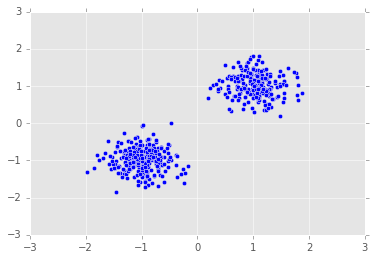

In [4]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()


In [5]:

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat


In [6]:
pi.shape,mu.shape,tf.sqrt(sigmasq).shape,N

(TensorShape([Dimension(3)]),
 TensorShape([Dimension(3), Dimension(2)]),
 TensorShape([Dimension(3), Dimension(2)]),
 500)

In [7]:
T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


In [8]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))


  5/500 [  1%]                                ETA: 60s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.01507574 -0.04333244]
 [-0.01567806  0.05245565]
 [-0.38376537 -0.31030524]]
 10/500 [  2%]                                ETA: 34s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.3954035   0.38058814]
 [ 0.31163675  0.2888777 ]
 [-0.64023083 -0.62653261]]
 15/500 [  3%]                                ETA: 24s | Acceptance Rate: 1.071
Inferred cluster means:
[[ 0.62532187  0.60930222]
 [ 0.52863616  0.53464282]
 [-0.76876676 -0.75037092]]
 20/500 [  4%] █                              ETA: 19s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.7340799   0.7261098 ]
 [ 0.63434577  0.65717053]
 [-0.83419037 -0.80503255]]
 25/500 [  5%] █                              ETA: 16s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.79558617  0.78727698]
 [ 0.67817622  0.64283913]
 [-0.86834908 -0.84366584]]
 30/500 [  6%] █                              ETA: 14s | Acceptance Ra

In [9]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)


In [10]:
clusters = tf.argmax(log_liks, 1).eval()


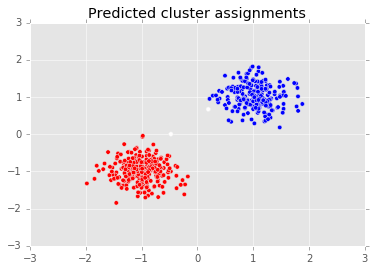

In [11]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()


# Analysis

# The mysteries boardcast mechanism

In [12]:
(np.empty((500,1,1,1)) * np.empty((100,2,2))).shape

(500, 100, 2, 2)

In [13]:
A = np.array([2]*500).reshape((500,1,1,1))

In [14]:
B = np.arange(400).reshape((100,2,2))

In [15]:
A.shape,B.shape

((500, 1, 1, 1), (100, 2, 2))

In [16]:
C = A * B

In [17]:
A[0] * B[0,0,0] == C[0,0,0,0]

array([[[ True]]], dtype=bool)

In [18]:
A[0] * B[0,0,1] == C[0,0,0,1]

array([[[ True]]], dtype=bool)

In [19]:
A[2] * B[3,0,1] == C[2,3,0,1]

array([[[ True]]], dtype=bool)

In [20]:
D = qmu.sample(100).eval()
D.shape

(100, 3, 2)

In [21]:
D[0]

array([[ 1.03837454,  1.03815901],
       [-0.75013745,  1.95411003],
       [-1.04331386, -0.9798857 ]], dtype=float32)

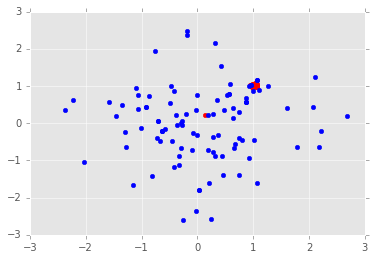

In [22]:
plt.scatter(D[:,0,0],D[:,0,1],label="I",color='red')
plt.scatter(D[:,1,0],D[:,1,1],label="II",color='blue')
#plt.legend('upper right')
plt.show()

## 2d burn in stage

In [23]:
E = qmu.params.eval()

In [24]:
E[0]

array([[-0.15130174, -0.18433464],
       [-0.03934331, -0.06122431],
       [-0.43350729, -0.20702393]], dtype=float32)

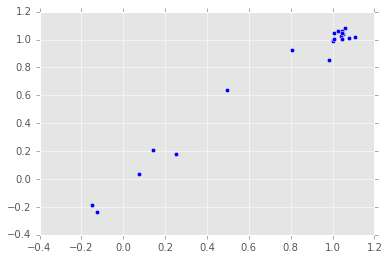

In [25]:
plt.scatter(E[:20,0,0],E[:20,0,1])
plt.show()

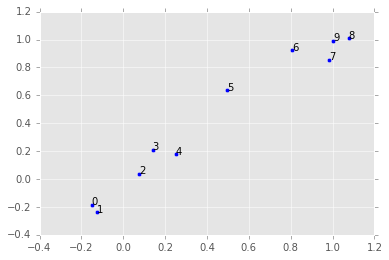

In [26]:
cut = 20
comp = 0
plt.scatter(E[:cut,comp,0],E[:cut,comp,1])
for x,y,name in zip(E[:cut,comp,0],E[:cut,comp,1],np.arange(cut)):
    plt.text(x,y,name)
plt.show()

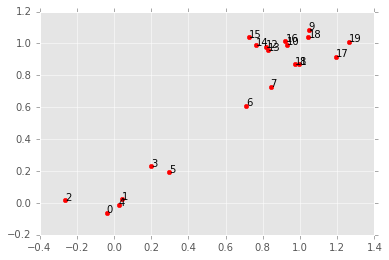

In [27]:
cut = 20
comp = 1
plt.scatter(E[:cut,comp,0],E[:cut,comp,1],color='red')
for x,y,name in zip(E[:cut,comp,0],E[:cut,comp,1],np.arange(cut)):
    plt.text(x,y,name)
plt.show()

In [28]:
x_broadcasted.shape

TensorShape([Dimension(500), Dimension(100), Dimension(3), Dimension(2)])

In [29]:
np.tile(1,5)

array([1, 1, 1, 1, 1])

In [30]:
np.tile([1,2],4)

array([1, 2, 1, 2, 1, 2, 1, 2])

In [31]:
np.tile([[1,2],[3,4]],2)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

In [32]:
np.tile([[1,2],[3,4]],[2,2])

array([[1, 2, 1, 2],
       [3, 4, 3, 4],
       [1, 2, 1, 2],
       [3, 4, 3, 4]])

In [33]:
np.tile([[[1,2],[3,4]],[[5,6],[7,8]]],[2,2])

array([[[1, 2, 1, 2],
        [3, 4, 3, 4],
        [1, 2, 1, 2],
        [3, 4, 3, 4]],

       [[5, 6, 5, 6],
        [7, 8, 7, 8],
        [5, 6, 5, 6],
        [7, 8, 7, 8]]])

In [34]:
np.array([[[1,2],[3,4]],[[5,6],[7,8]]]).shape ,np.array([2,3]).shape

((2, 2, 2), (2,))

In [35]:
np.tile([[[1,2],[3,4]],[[5,6],[7,8]]],[1,2,3]).shape

(2, 4, 6)

(array([   8.,   19.,   67.,  113.,  167.,   95.,   30.,    1.,   17.,  983.]),
 array([-69.27220154, -62.29552343, -55.31884532, -48.34216721,
        -41.3654891 , -34.38881099, -27.41213288, -20.43545477,
        -13.45877666,  -6.48209856,   0.49457955]),
 <a list of 10 Patch objects>)

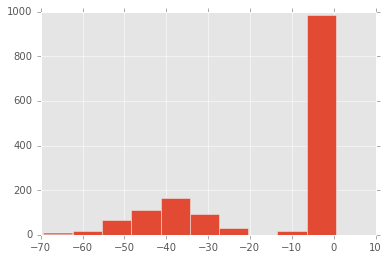

In [36]:
plt.hist(list(log_liks.eval().flat))

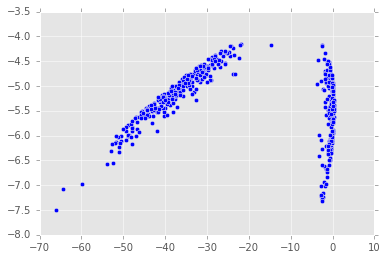

In [37]:
plt.scatter(log_liks.eval()[:,0],log_liks.eval()[:,1])
plt.show()

## Reimplement for 1d case

In [3]:
def build_toy_dataset(N):
    pi = [0.3,0.7]
    ms = [-10.1,10.2]
    stds = [2,0.9]
    data = np.empty(N)
    for i in range(N):
        cat = np.argmax(np.random.multinomial(1,pi))
        data[i] = np.random.normal(ms[cat], stds[cat])
    return data

In [4]:
data = build_toy_dataset(500)

(array([   6.,   53.,   65.,   19.,    2.,    0.,    0.,    0.,  105.,  250.]),
 array([-16.54107502, -13.61992914, -10.69878326,  -7.77763738,
         -4.8564915 ,  -1.93534563,   0.98580025,   3.90694613,
          6.82809201,   9.74923789,  12.67038377]),
 <a list of 10 Patch objects>)

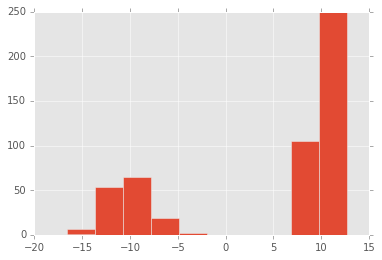

In [5]:
plt.hist(data)

### Gibs method

In [41]:
pi = ed.models.Dirichlet(tf.ones(2))
mu = ed.models.Normal(0.0,4.0,sample_shape=2)
std = ed.models.InverseGamma(1.0,1.0,sample_shape=2) # the name is wrong, it's std^2 in fact.
#std = ed.models.Chi2(1.0,sample_shape=2) 

x = ed.models.ParamMixture(pi, 
                           {'loc':mu,'scale':tf.sqrt(std)},
                           ed.models.Normal,
                           sample_shape=500)
z = x.cat

(array([   7.,   23.,   73.,  113.,  110.,   86.,   52.,   26.,    9.,    1.]),
 array([-5.36726713, -4.7278654 , -4.08846366, -3.44906193, -2.8096602 ,
        -2.17025846, -1.53085673, -0.89145499, -0.25205326,  0.38734847,
         1.02675021]),
 <a list of 10 Patch objects>)

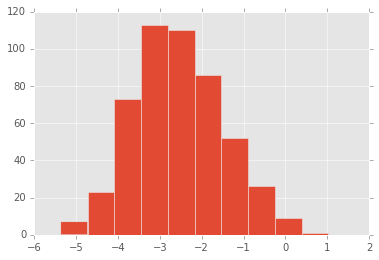

In [42]:
plt.hist(x.eval())

In [43]:
T = 3000

qpi = Empirical(tf.Variable(tf.ones([T,2]) / 2))
qmu = Empirical(tf.Variable(tf.zeros([T,2])))
qstd = Empirical(tf.Variable(tf.ones([T,2])))

qz = Empirical(tf.Variable(tf.zeros([T, 500], dtype=tf.int32)))


In [44]:
inference = ed.Gibbs({pi:qpi, mu:qmu, std:qstd, z:qz}, data={x:data})
#inference = ed.Gibbs({pi:qpi, mu:qmu, std:qstd}, data={x:data})

In [45]:
inference.run()

3000/3000 [100%] ██████████████████████████████ Elapsed: 13s | Acceptance Rate: 1.000


In [46]:
trace = qmu.params.eval()

-9.8221


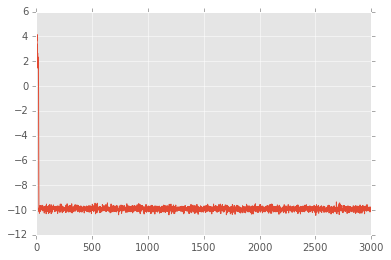

In [47]:
print(np.mean(trace[:,0]))
plt.plot(trace[:,0])

10.2666


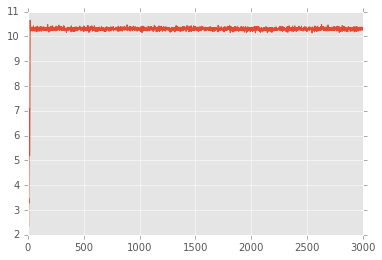

In [48]:
print(np.mean(trace[:,1]))
plt.plot(trace[:,1])

In [49]:
trace = np.sqrt(qstd.params.eval())

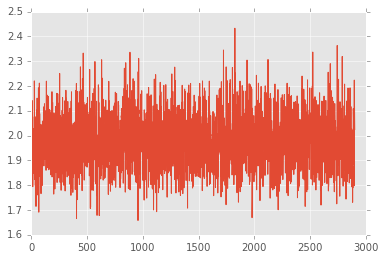

In [50]:
plt.plot(trace[100:,0])

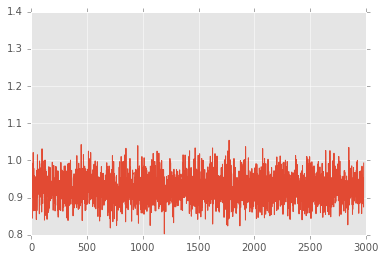

In [51]:
plt.plot(trace[20:,1])

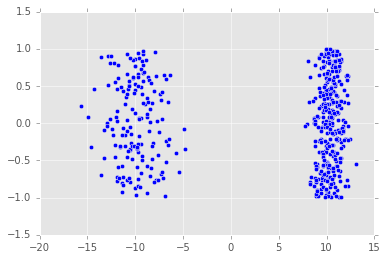

In [52]:
plt.scatter(data,np.random.uniform(-1,1,data.shape[0]))

In [53]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qstd.sample(100)
x_post = Normal(loc=tf.ones([500, 1, 1]) * mu_sample,
                scale=tf.ones([500, 1, 1]) * tf.sqrt(sigmasq_sample))
data = data.astype('float32')
x_broadcasted = tf.tile(tf.reshape(data, [500, 1, 1]), [1, 100, 2])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_mean(log_liks, 1)


In [54]:
clusters = tf.argmax(log_liks, 1).eval()


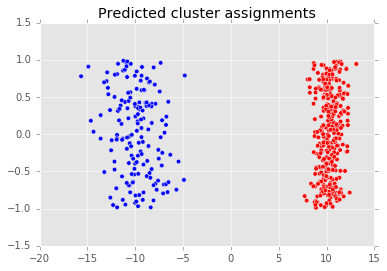

In [55]:
plt.scatter(data,np.random.uniform(-1,1,data.shape[0]), c=clusters, cmap=cm.bwr)
#plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()


### MetropolisHastings method

In [15]:
pi = ed.models.Dirichlet(tf.ones(2))
mu = ed.models.Normal(0.0,4.0,sample_shape=2)
#stdsq = ed.models.Chi2(1.0,sample_shape=2)
stdsq = ed.models.InverseGamma(1.0,1.0,sample_shape=2)


x = ed.models.ParamMixture(pi, 
                           {'loc':mu,'scale':tf.sqrt(stdsq)},
                           ed.models.Normal,
                           sample_shape=500)
z = x.cat

In [16]:
T = 20000

qpi = Empirical(tf.Variable(tf.ones([T,2]) / 2))
qmu = Empirical(tf.Variable(tf.zeros([T,2])))
qstdsq = Empirical(tf.Variable(tf.ones([T,2])))

qz = Empirical(tf.Variable(tf.zeros([T, 500], dtype=tf.int32)))


In [17]:
#gpi = ed.models.Dirichlet(pi)
#gpi = Dirichlet(concentration=tf.constant([1.4, 1.6]))
#gpi = Dirichlet(concentration=tf.constant([1.4, 1.6]))
gpi = Dirichlet(concentration=pi)

#gmu = ed.models.Normal(0.0,1.0,sample_shape=2)
gmu = ed.models.Normal(mu,0.1)
#gmu = ed.models.Uniform(0.0,1.0,sample_shape=2)
#gstd = ed.models.InverseGamma(1.0,1.0,sample_shape=2)
#gstd = ed.models.Chi2(std)
gstdsq = ed.models.Normal(stdsq,0.1)




In [18]:
inference = ed.MetropolisHastings({pi:qpi, mu:qmu, stdsq:qstdsq,},
                                  {pi:gpi, mu:gmu, stdsq:gstdsq,},
                                  data={x:data})


In [19]:
inference.run()

100000/100000 [100%] ██████████████████████████████ Elapsed: 80s | Acceptance Rate: 0.264


In [20]:
trace = qmu.params.eval()

0.413548


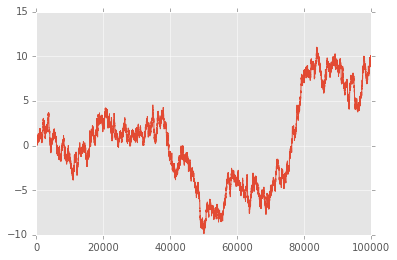

In [21]:
print(np.mean(trace[:,0]))
plt.plot(trace[:,0])

-1.16392


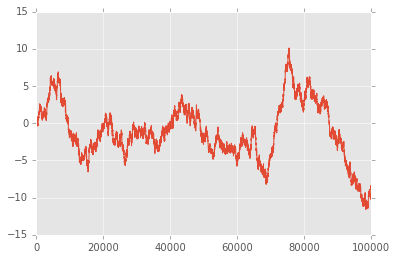

In [22]:
print(np.mean(trace[:,1]))
plt.plot(trace[:,1])

In [23]:
trace = np.sqrt(qstdsq.params.eval())

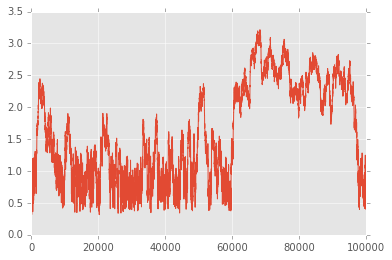

In [24]:
plt.plot(trace[:,0])

1.24781e-06


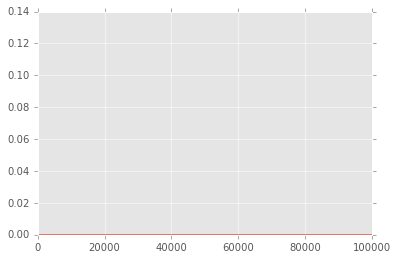

In [25]:
trace = qpi.params.eval()
print(np.mean(trace[:,0]))
plt.plot(trace[:,0])

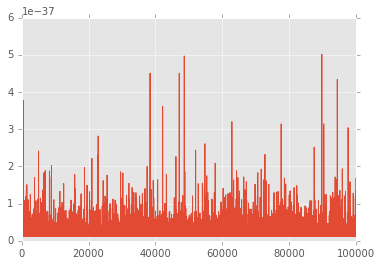

In [27]:
plt.plot(trace[10:,0])

0.999999


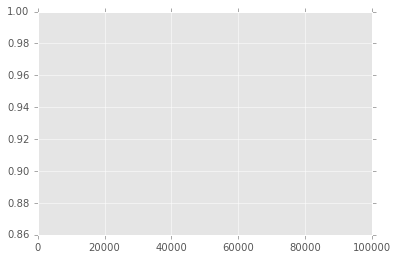

In [28]:
trace = qpi.params.eval()
print(np.mean(trace[:,1]))
plt.plot(trace[:,1])

## Hybrid Monte Carlo


In [70]:
pi = ed.models.Dirichlet(tf.ones(2))
mu = ed.models.Normal(0.0,4.0,sample_shape=2)
#stdsq = ed.models.Chi2(1.0,sample_shape=2)
stdsq = ed.models.InverseGamma(1.0,1.0,sample_shape=2) # the name is wrong, it's std^2 in fact.

x = ed.models.ParamMixture(pi, 
                           {'loc':mu,'scale':tf.sqrt(stdsq)},
                           ed.models.Normal,
                           sample_shape=500)
z = x.cat

In [71]:
T = 10000

qpi = Empirical(tf.Variable(tf.ones([T,2]) / 2))
qmu = Empirical(tf.Variable(tf.zeros([T,2])))
qstdsq = Empirical(tf.Variable(tf.ones([T,2])))

qz = Empirical(tf.Variable(tf.zeros([T, 500], dtype=tf.int32)))


In [72]:
inference = ed.HMC({pi:qpi, mu:qmu, stdsq:qstdsq},
                                  data={x:data})


In [73]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 12s | Acceptance Rate: 0.488


In [74]:
trace = qmu.params.eval()

-0.909592


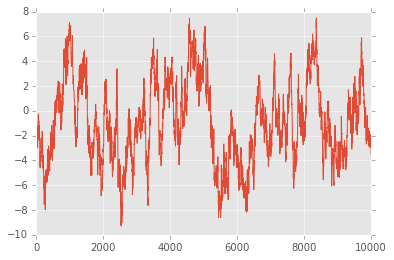

In [75]:
print(np.mean(trace[:,0]))
plt.plot(trace[:,0])

-0.564734


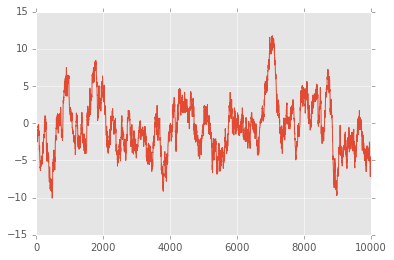

In [76]:
print(np.mean(trace[:,1]))
plt.plot(trace[:,1])

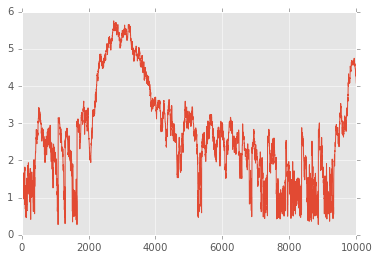

In [77]:
trace = np.sqrt(qstdsq.params.eval())
plt.plot(trace[:,0])

## Stochastic gradient Hamiltonian Monte Carlo

In [94]:
pi = ed.models.Dirichlet(tf.ones(2))
mu = ed.models.Normal(0.0,4.0,sample_shape=2)
std = ed.models.InverseGamma(1.0,1.0,sample_shape=2) # the name is wrong, it's std^2 in fact.
#std = ed.models.Chi2(1.0,sample_shape=2) 

x = ed.models.ParamMixture(pi, 
                           {'loc':mu,'scale':tf.sqrt(std)},
                           ed.models.Normal,
                           sample_shape=500)
z = x.cat

In [95]:
T = 10000

qpi = Empirical(tf.Variable(tf.ones([T,2]) / 2))
qmu = Empirical(tf.Variable(tf.zeros([T,2])))
qstd = Empirical(tf.Variable(tf.ones([T,2])))

qz = Empirical(tf.Variable(tf.zeros([T, 500], dtype=tf.int32)))


In [96]:
#inference = ed.SGHMC({pi:qpi, mu:qmu, std:qstd, z:qz}, data={x:data})
inference = ed.SGHMC({pi:qpi, mu:qmu, std:qstd}, data={x:data})

In [97]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 35s | Acceptance Rate: 1.000


In [98]:
trace = qmu.params.eval()

0.817542


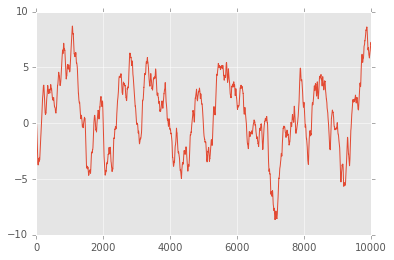

In [99]:
print(np.mean(trace[:,0]))
plt.plot(trace[:,0])

-0.113372


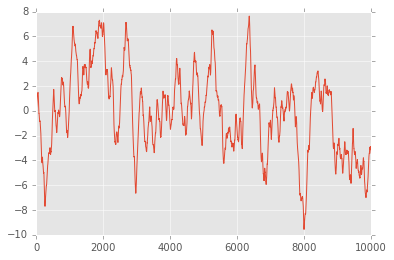

In [100]:
print(np.mean(trace[:,1]))
plt.plot(trace[:,1])